In [1]:
from __future__ import print_function
from __future__ import absolute_import

import os
import sys
import tensorflow as tf
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from IPython import display

%matplotlib inline

In [2]:
# DLTK imports  
import dltk.core.modules as modules
from dltk.models.segmentation.unet import ResUNET

import mrbrains_reader as reader

# Set the CUDA_VISIBLE_DEVICES environmental variable to GPU ids to compute on
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

# Save path for log files and model parameters
save_path =  '/tmp/MRBrainS13'
os.system("rm -rf " + save_path)

tf.logging.set_verbosity(tf.logging.ERROR)

In [3]:
# Get a list of paths to the training images, interpretable by the custom MRBrainS13 file reader
def train_files():
    return [["../../data/MRBrainS13DataNii/TrainingData/1/",
            "../../data/MRBrainS13DataNii/TrainingData/2/",
            "../../data/MRBrainS13DataNii/TrainingData/3/",
            "../../data/MRBrainS13DataNii/TrainingData/4/",
            "../../data/MRBrainS13DataNii/TrainingData/5/"]]

                 # Set up a batcher op to spawn a custom reader and produce pairs of training images and
# labels (X_train and Y_train, respectively). These pairs are 5D tf.Tensors with the dimensions
# [batch_size, x, y, z, num_channels]. Our reader will produce axial slice training examples of shape
# [4, 1, 256, 256, 3]
num_classes = 9
num_channels = 3
batch_size = 4

# I/O ops for training and validation via a custom mrbrains_reader
x_train, y_train = reader.MRBrainsReader([tf.float32, tf.int32], [[1, 64, 64, 3], [1, 64, 64]], name='train_queue')(
    train_files(), batch_size=batch_size, n_examples=18, min_queue_examples=batch_size * 2, capacity=batch_size * 4)    

# Create a segmentation network. Here we use a U-NET [1] architecture with residual feature encoder [2].
# Strided convolutions are employed for downsampling, resulting in 3 feature scales, each with two 
# residual units.
# [1] O.Ronneberger et al. (2015). U-net: Convolutional networks for biomedical image segmentation. MICCAI.
# [2] K.He et al (2016). Deep residual learning for image recognition. IEEE CVPR.
net = ResUNET(num_classes, 
              num_residual_units=2,
              filters=[16, 32, 64],
              strides=[[1,1,1], [1,2,2], [1,2,2]])

# For training, we compute the mean categorical crossentropy as a loss function
train_logits_ = net(x_train)['logits']
train_truth_ = y_train
crossentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=train_logits_, labels=train_truth_)
train_loss_ = tf.reduce_mean(crossentropy, name='crossentropy')

# Set up an optimiser
train_op_ = tf.train.MomentumOptimizer(0.001, 0.9).minimize(train_loss_)

(?, 1, 64, 64, 16)
(?, 1, 32, 32, 32)
(?, 1, 16, 16, 64)
(?, 1, 32, 32, 32)
(?, 1, 64, 64, 16)


In [4]:
# Additional ops to visualise the segmentation output
out_y_ = net(x_train, is_training=False)['y_']
global_step = tf.Variable(0, name='global_step', trainable=False)

(?, 1, 64, 64, 16)
(?, 1, 32, 32, 32)
(?, 1, 16, 16, 64)
(?, 1, 32, 32, 32)
(?, 1, 64, 64, 16)


In [5]:
# Set up a supervisor to continuously save and log the training progress, handle queues and initialise variables 
step = 0
loss_moving = []  
sv = tf.train.Supervisor(logdir=save_path,
                         is_chief=True,
                         summary_op=None,
                         save_summaries_secs=30,
                         save_model_secs=60,
                         global_step=global_step)

s = sv.prepare_or_wait_for_session(config=tf.ConfigProto())

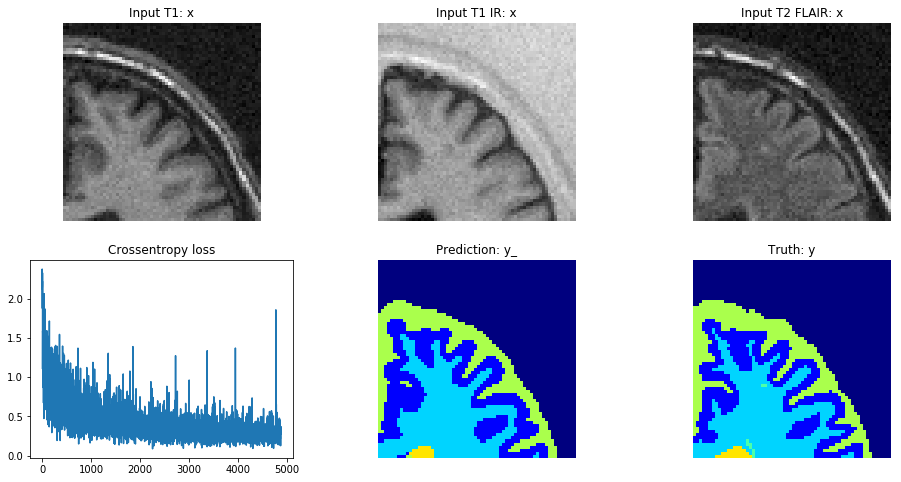

In [6]:
# Main training loop
for _ in range(10000):

    # Run the training op and log the ce loss
    _, loss = s.run([train_op_, train_loss_])
    loss_moving.append(loss)    

    # Run a forward pass and return prediction (y_), input image (x) and corresponding truth (y)
    y_, x, y = s.run([out_y_, x_train, y_train])
    
    # Visualise all inputs, outputs and losses during each training step
    if True:
        f, axarr = plt.subplots(2, 3, figsize=(16,8))
        axarr[0,0].imshow(np.squeeze(x[0,0,:,:,0]), cmap='gray')
        axarr[0,0].set_title('Input T1: x')
        axarr[0,0].axis('off')

        axarr[0,1].imshow(np.squeeze(x[0,0,:,:,1]), cmap='gray')
        axarr[0,1].set_title('Input T1 IR: x')
        axarr[0,1].axis('off')

        axarr[0,2].imshow(np.squeeze(x[0,0,:,:,2]), cmap='gray')
        axarr[0,2].set_title('Input T2 FLAIR: x')
        axarr[0,2].axis('off')

        axarr[1,0].plot(loss_moving)
        axarr[1,0].set_title('Crossentropy loss')
        axarr[1,0].axis('on')

        axarr[1,1].imshow(np.squeeze(y_[0,0,:,:]), cmap='jet', vmin=0, vmax=num_classes)
        axarr[1,1].set_title('Prediction: y_')
        axarr[1,1].axis('off')

        axarr[1,2].imshow(np.squeeze(y[0,0,:,:]), cmap='jet', vmin=0, vmax=num_classes)
        axarr[1,2].set_title('Truth: y')
        axarr[1,2].axis('off')

        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.close(f)

    step += 1